# Preamble

I chose Exercise 3: Reddit Data partly because of our previous discussion on how LLMs could be used to advance the goals of Pivotal Life Science. Based on the preliminary understanding that I've collected, this problem provides an opportunity to develop an initial LLM capability that could be expanded starting on day 1 at the job.

The work in this notebook is an analysis that does not consider the text itself and idenfies a several features that could be combined with LLM outputs to predict post success.


# tl;dr

- Statistical modeling is helpful with interpretation, helping indentify several predictors
- Topic, time features, and text derived features are all predictive of succesful posts
- The R2 of this appoach is 0.15

# Data exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import statsmodels.api as sm

reddit_df = pd.read_csv('./askscience_data.csv', index_col=0)
reddit_df

,title,body,tag,datetime,author,score,upvote_ratio,url
0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...
1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...
2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...
3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...
4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...
...,...,...,...,...,...,...,...,...
795,I heard some electron microscopes use gallium....,NaN,Engineering,2022-01-12 17:14:35,Emma_Dale20,6.0,0.70,https://www.reddit.com/r/askscience/comments/s...
796,is the spread of COVID typical for a respirato...,i understand that there's no respiratory virus...,COVID-19,2022-01-12 09:39:55,aggasalk,27.0,0.74,https://www.reddit.com/r/askscience/comments/s...
797,What is the technical difference between Cheek...,What are the technical difference(s) between t...,COVID-19,2022-01-12 14:47:28,h110hawk,3.0,0.67,https://www.reddit.com/r/askscience/comments/s...
798,What starts the coagulation cascade during blo...,I understand that stasis of blood increases th...,Human Body,2022-01-12 14:20:26,joegoldbergg,5.0,0.78,https://www.reddit.com/r/askscience/comments/s...


## Observations

The dataset is of modest size and relatively simple. As a light user of reddit, all the columns make sense to me, but I am not entirely clear about the score and upvote_ratio.

Based on https://www.reddit.com/wiki/faq/, we see the following description of the score.


### How is a submission's score determined?
A submission's score is simply the number of upvotes minus the number of downvotes. If five users like the submission and three users don't it will have a score of 2. Please note that the vote numbers are not "real" numbers, they have been "fuzzed" to prevent spam bots etc. So taking the above example, if five users upvoted the submission, and three users downvote it, the upvote/downvote numbers may say 23 upvotes and 21 downvotes, or 12 upvotes, and 10 downvotes. The points score is correct, but the vote totals are "fuzzed".

Based on https://www.reddit.com/r/reddithelp/comments/10lvny1/whats_the_real_definition_of_upvote_rate/, we have the following critial review of the upvote ratio.

### What's the real definition of "Upvote Rate"?
... The (mouseover pop-up) help on the reddit upvote rate is flat-out wrong, but it should be trivial to fix it.
That (mouseover) help says the upvote rate is the ratio of the number of upvotes and downvotes on your post.
That can't be right, since the results are between 0 and 100%. I also think it means, or should mean, the percentage of upvotes among all votes cast.
For instance, if you have 4 upvotes and 6 downvotes, that's 10 vote total. I would think that the upvote rate should be 4/10 = 40%. If there's a ratio, it's 4/6 , = 66% .
But if there's 10 upvotes and 1 downvote, the ratio would be 10/1 = a ratio of 10, which implies something more like 900% or 1000%, depending on how you interpret that.
I've never seen an upvote rate greater than 100%, which tells you it CANNOT be a ratio of upvotes to downvotes, because the ratio goes over 1 (100%) for any case where there's more upvotes than downvotes.
If there's 10 upvotes and 0 downvotes, the ratio is 10/0 , which isn't even defined. The help should be fixed.


The histogram of scores is consistent with the above definition. All available values are whole numbers and the distribution is long tailed.

<Axes: >

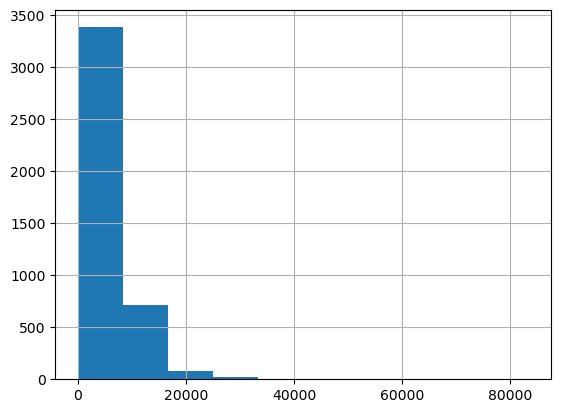

In [2]:
reddit_df.score.hist()

Similarly, the histogram of upvote ratios is between 0-1, confirming that it reflects a proportion, rather than the ratio between positive and negative votes. Interestingly, it suggests a biased towards positive votes, which is somewhat the opposite of the impression one gets from the right-side tail of scores.

<Axes: >

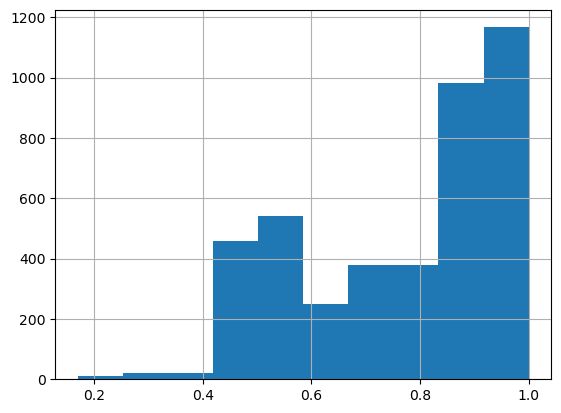

In [3]:
reddit_df.upvote_ratio.hist()

We can directly evaluate the correlation between both variables.

r=0.8374923422904555, p=0.0


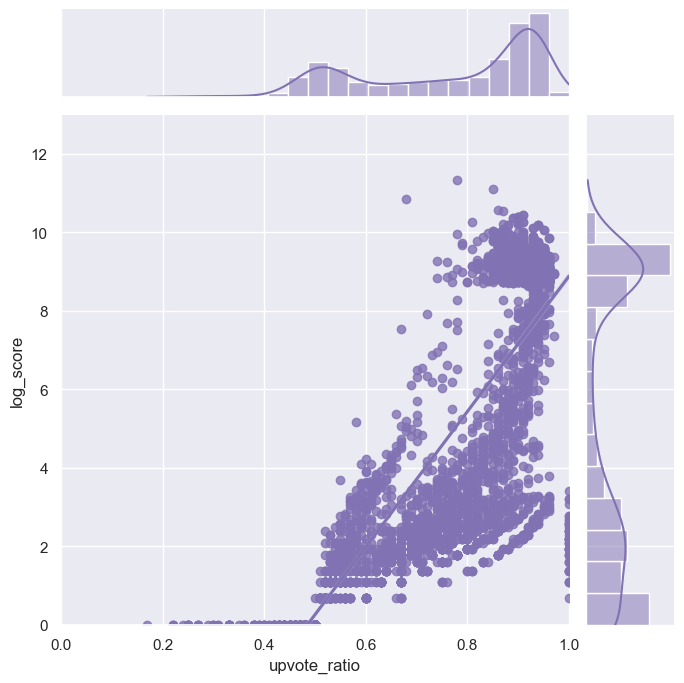

In [4]:
reddit_df['log_score'] = np.log(1+reddit_df.score)

sns.set_theme(style="darkgrid")
sns.jointplot(x="upvote_ratio", y="log_score", data=reddit_df,
                  kind="reg", truncate=False,
                  xlim=(0, 1), ylim=(0, 13),
                  color="m", height=7)
r, p = st.mstats.pearsonr(reddit_df.upvote_ratio, reddit_df.log_score)
print(f'r={r}, p={p}')

We can also evaluate whether the length of the post is a good predictor of score. Although the relationship is weak, it seems like shorter posts perform better.

r=-0.08864653648018517, p=8.511640956631311e-09


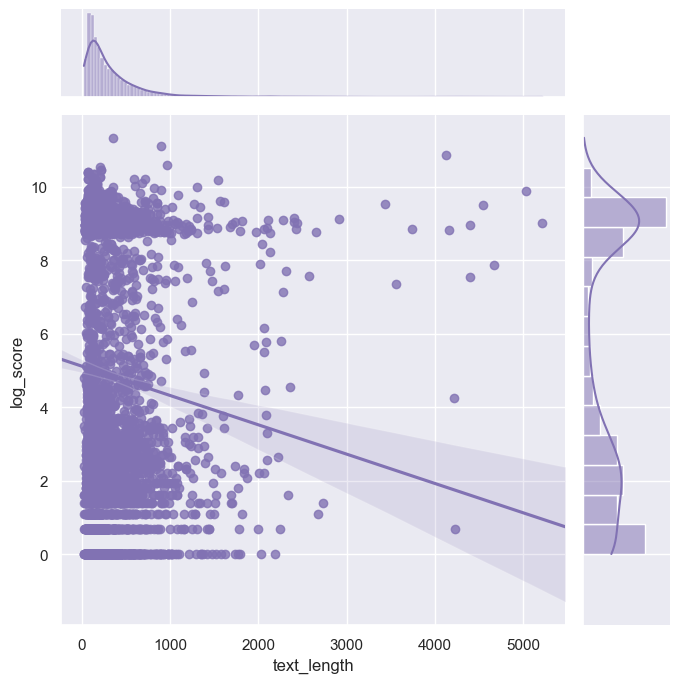

In [5]:
reddit_df['full_text'] =  reddit_df.apply(lambda x: str(x.title) + ' ' + str(x.body), axis=1)
reddit_df['text_length'] = reddit_df.full_text.apply(lambda x: len(x))

sns.set_theme(style="darkgrid")
sns.jointplot(
    x="text_length", 
    y="log_score", 
    data=reddit_df,
    kind="reg", 
    truncate=False,
    # xlim=(0, 1), 
    # ylim=(0, 13),
    color="m", 
    height=7
)
r, p = st.mstats.pearsonr(reddit_df.text_length, reddit_df.log_score)
print(f'r={r}, p={p}')

A number of other features could be predictive of score. Building a statistical model may be the best way to evaluate them all at once.

# Statistical model: GLM

In [6]:
# add some time related features
reddit_df['datetime'] = reddit_df.datetime.astype(np.datetime64)
reddit_df['year'] = reddit_df.datetime.dt.year
reddit_df['month'] = reddit_df.datetime.dt.month
reddit_df['day_of_year'] = reddit_df.datetime.dt.day_of_year
reddit_df['day_of_month'] = reddit_df.datetime.dt.day
reddit_df['day_of_week'] = reddit_df.datetime.dt.day_of_week
reddit_df['hour'] = reddit_df.datetime.dt.hour

In [9]:
reddit_df.head()

,title,body,tag,datetime,author,score,upvote_ratio,url,log_score,full_text,text_length,year,month,day_of_year,day_of_month,day_of_week,hour
0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...,7.203406,Post viral cough: why does it get worse after ...,1606,2022,12,343,9,4,2
1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...,6.056784,Can an x-ray of an adult show chronic malnouri...,308,2022,12,342,8,3,18
2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...,7.704812,[META] Bots and AI tools on r/askscience \n\n...,563,2022,12,342,8,3,9
3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...,3.891820,Can you predictably manipulate a magnetic gas?...,594,2022,12,342,8,3,20
4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...,2.708050,Are there cells in humans (or other mammals) t...,77,2022,12,343,9,4,1


In [21]:
reddit_df['constant'] = 1

dummies = pd.get_dummies(reddit_df['tag'], drop_first=True)
continuous = ['constant', 'text_length', 'year', 'month', 
              'day_of_year', 'day_of_month', 'day_of_week', 'hour']
X = pd.concat([reddit_df[continuous], dummies], axis=1)
model = sm.OLS(reddit_df.log_score, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              log_score   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     19.34
Date:                Fri, 29 Sep 2023   Prob (F-statistic):          1.41e-118
Time:                        18:30:38   Log-Likelihood:                -11075.
No. Observations:                4205   AIC:                         2.223e+04
Df Residuals:                    4166   BIC:                         2.248e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
constant          

# Summary

The above model does a relatively decent job at predicting log_score, achieving an R2 of 0.15, and revealing a number of significant predictors.

The constant is clearly significant, indicating that the average post in our dataset gets a log score of 584.3796.

As previously uncovered, text length is negatively related to score, such that longer posts achieve lower scores. Also, more recent years, days closer to the end of the year, and late night posts are all associated with lower scores. This has to be considered in light of the fact that later months and later days in the month are associated with higher scores. More careful parsing out of time is required to clarify these relationships.

Finally, different topics are associated with different scores, most being associated with higher scores than the excluded level (more time would allow me to check exactly), but some like food, and interdisciplinary being associated with lower scores than the default.